In [1]:
%autosave 30
import pandas as pd
import numpy as np
from scipy.stats import norm
from scipy.optimize import brentq
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
import datetime as dt
from scipy.interpolate import interp1d
import seaborn as sns; sns.set(rc = {'figure.figsize' : (15,9)})
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

Autosaving every 30 seconds


In [2]:
from scipy.optimize import least_squares

beta = 0.7

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], beta, x[1], x[2]))**2

    return err


def impliedVolatility(S, K, r, price, T, payoff):
    try:
        if (payoff.lower() == 'call'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalCall(S, K, r, x, T),
                                1e-12, 10.0)
        elif (payoff.lower() == 'put'):
            impliedVol = brentq(lambda x: price -
                                BlackScholesLognormalPut(S, K, r, x, T),
                                1e-12, 10.0)
        else:
            raise NameError('Payoff type not recognized')
    except Exception:
        impliedVol = np.nan

    return impliedVol


def BlackScholesLognormalCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)


def BlackScholesLognormalPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)


# SPX options implied volatility

In [6]:
df

,date,exdate,cp_flag,strike_price,best_bid,best_offer,exercise_style
0,20201201,20201218,C,100000,3547.6,3570.5,E
1,20201201,20201218,C,200000,3447.6,3470.5,E
2,20201201,20201218,C,300000,3347.7,3370.6,E
3,20201201,20201218,C,400000,3247.7,3270.6,E
4,20201201,20201218,C,500000,3147.7,3170.6,E
...,...,...,...,...,...,...,...
2067,20201201,20210219,P,5000000,1333.1,1350.5,E
2068,20201201,20210219,P,5100000,1431.8,1454.7,E
2069,20201201,20210219,P,5200000,1531.7,1554.6,E
2070,20201201,20210219,P,5300000,1631.5,1654.4,E


In [5]:
dr = pd.read_csv('zero_rates_20201201.csv')
df = pd.read_csv('spx_options.csv')

In [7]:
S = 3662.45
today = dt.date(2020,12,1)
expiries = [pd.Timestamp(str(x)).date() for x in df['exdate'].unique()]
T = [(exdate - today).days / 365.0 for exdate in expiries]

In [8]:
expiries

[datetime.date(2020, 12, 18),
 datetime.date(2021, 1, 15),
 datetime.date(2021, 2, 19)]

In [12]:
[(exdate - today).days / 1 for exdate in expiries]

[17.0, 45.0, 80.0]

In [15]:
x = [13, 49, 77, 104]
y = [dr['rate'][1], dr['rate'][2], dr['rate'][3], dr['rate'][4]]

f = interp1d(x, y) # interpolation

r17 = float(f(17))/100
r45 = float(f(45))/100
r80 = float(f(80))/100

df['cp_flag'] = df['cp_flag'].apply(lambda x: 'call' if x == 'C' else 'put')
df['price'] = (df['best_bid'] + df['best_offer']) / 2
df['duration'] = df['exdate'].apply(lambda x: (expiries[0] - today).days 
                                    if x == 20201218 
                                    else (expiries[1] - today).days if x == 20210115
                                    else (expiries[2] - today).days
                                   )


df['T'] = df['exdate'].apply(lambda x: T[0] if x == 20201218 
                             else T[1] if x == 20210115 
                             else T[2]
                            )
df['r'] = df['duration'].apply(lambda x:
                              r17 if x == 17
                              else r45 if x == 45
                              else r80)
df['strike_price'] = df['strike_price']/1000
df['Forward'] = S*np.exp(df['r']*df['T'])
df['mid_price'] = (df['best_bid'] + df['best_offer'])/2
for i in range(df.shape[0]):
    if df['cp_flag'][i] == 'call':
        if df['strike_price'][i] < df['Forward'][i]:
            df = df.drop(i)
    else:
        if df['strike_price'][i] > df['Forward'][i]:
            df  = df.drop(i)
df = df.reset_index(drop = True)       
impliedvol = []
for i in range(df.shape[0]):
    impliedvol.append(impliedVolatility(S, 
                                        df['strike_price'][i], 
                                        df['r'][i], 
                                        df['price'][i], 
                                        df['T'][i], 
                                        df['cp_flag'][i]
                                       )
                     )
df['impliedvol'] = impliedvol

days17 = df[df['exdate'] == 20201218].reset_index(drop = True)
days45 = df[df['exdate'] == 20210115].reset_index(drop = True)
days80 = df[df['exdate'] == 20210219].reset_index(drop = True)

In [17]:
T17 = days17['T'][0]
F17 = days17['Forward'][0]

T45 = days45['T'][0]
F45 = days45['Forward'][0]

T80 = days80['T'][0]
F80 = days80['Forward'][0]

R17 = df['r'].unique()[0]
R45 = df['r'].unique()[1]
R80 = df['r'].unique()[2]

In [24]:
res

 active_mask: array([0., 0., 0.])
        cost: 0.8719838228087514
         fun: array([1.32059367])
        grad: array([ 5.82240070e-04, -1.34698505e-04, -7.65507980e-05])
         jac: array([[ 4.40892670e-04, -1.01998448e-04, -5.79669581e-05]])
     message: '`ftol` termination condition is satisfied.'
        nfev: 195
        njev: 192
  optimality: 0.0005822400704364299
      status: 2
     success: True
           x: array([ 1.21228995, -0.30090028,  5.45976144])

In [23]:
initialGuess = [0.02, 0.2, 0.1]

res = least_squares(lambda x: sabrcalibration(x,
                                              days17['strike_price'],
                                              days17['impliedvol'],
                                              F17,
                                              T17),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

C:\Users\Sherr\AppData\Local\Temp/ipykernel_34456/1474113876.py:22: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
C:\Users\Sherr\AppData\Local\Temp/ipykernel_34456/1474113876.py:22: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.212, beta = 0.7, rho = -0.301, nu = 5.460


# Comparion of market volatilities vs SABR volatilities for options with 17 days duration

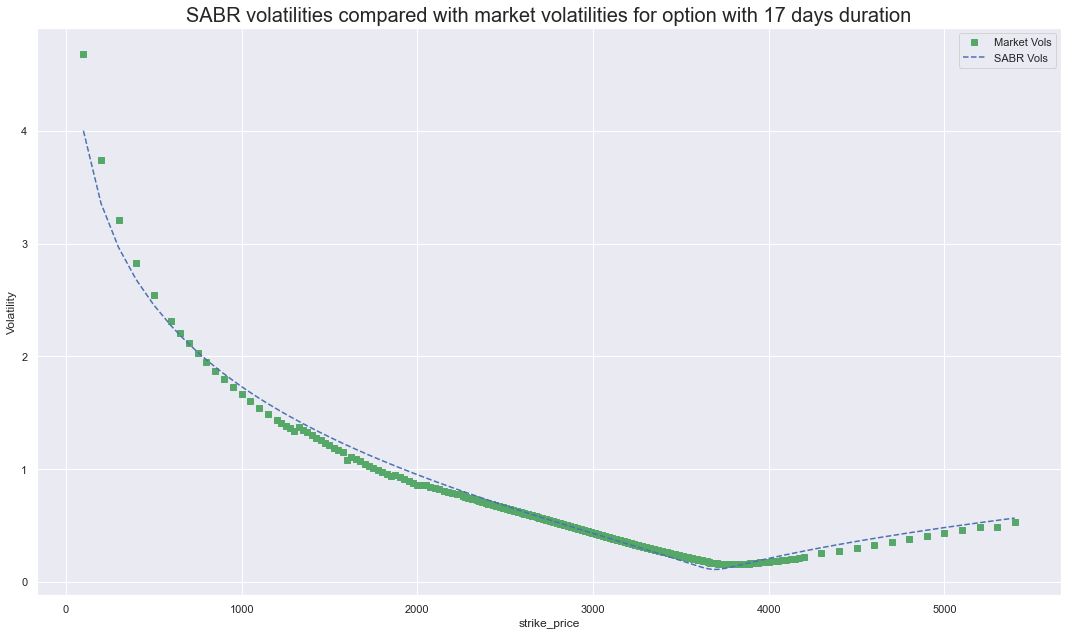

In [6]:
sabrvols = []
for K in days17['strike_price']:
    sabrvols.append(SABR(F17, K, T17, alpha, beta, rho, nu))

plt.figure(tight_layout=True)
plt.plot(days17['strike_price'], days17['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days17['strike_price'], y = sabrvols, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 17 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Comparion of market volatilities vs SABR volatilities for options with 45 days duration

In [7]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days45['strike_price'],
                                              days45['impliedvol'],
                                              F45,
                                              T45),
                    initialGuess)
alpha1 = res.x[0]
rho1 = res.x[1]
nu1 = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha1, beta, rho1, nu1))

<ipython-input-1-d27e121ebd9d>:22: RuntimeWarning: invalid value encountered in log
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
<ipython-input-1-d27e121ebd9d>:22: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.817, beta = 0.7, rho = -0.404, nu = 2.790


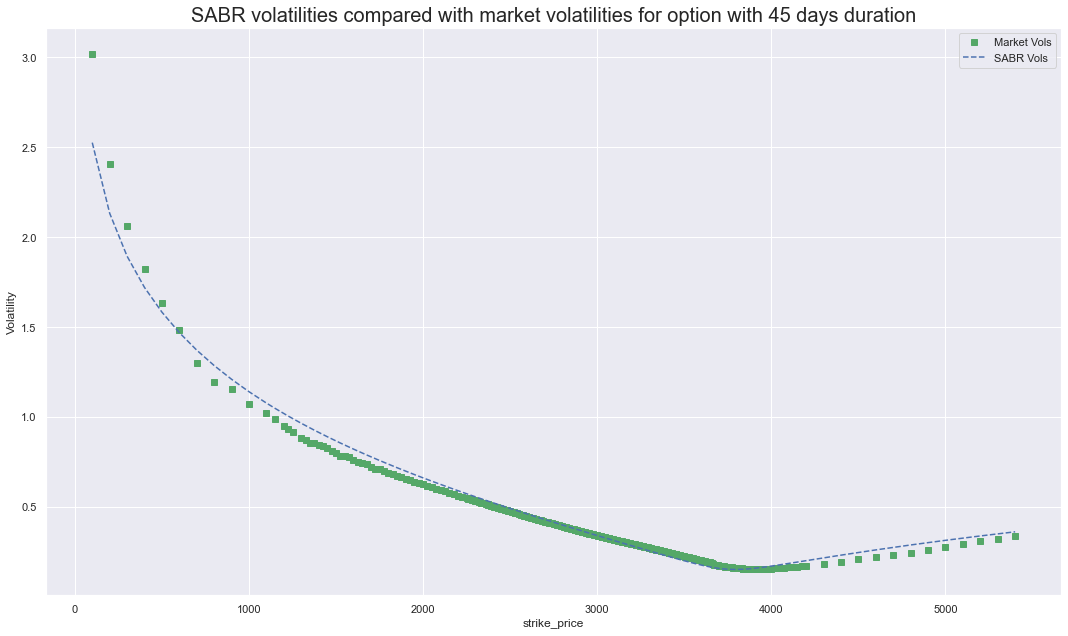

In [8]:
sabrvols1 = []
for K in days45['strike_price']:
    sabrvols1.append(SABR(F45, K, T45, alpha1, beta, rho1, nu1))

plt.figure(tight_layout=True)
plt.plot(days45['strike_price'], days45['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days45['strike_price'], y = sabrvols1, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 45 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Comparion of market volatilities vs SABR volatilities for options with 80 days duration

In [9]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days80['strike_price'],
                                              days80['impliedvol'],
                                              F80,
                                              T80),
                    initialGuess)
alpha2 = res.x[0]
rho2 = res.x[1]
nu2 = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha2, beta, rho2, nu2))

Calibrated SABR model parameters: alpha = 2.140, beta = 0.7, rho = -0.575, nu = 1.842


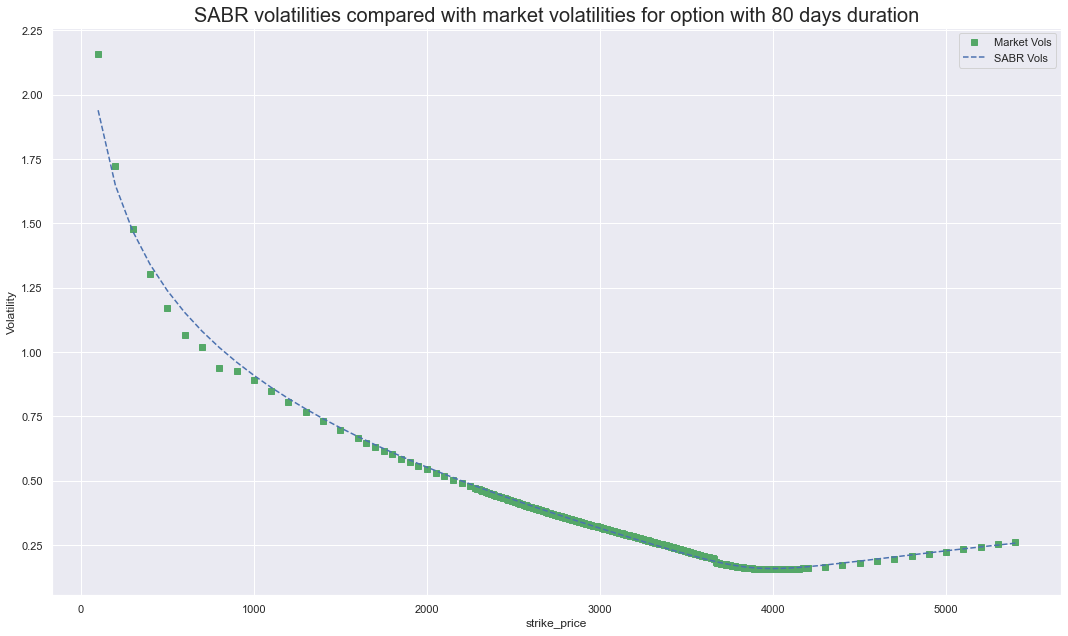

In [10]:
sabrvols2 = []
for K in days80['strike_price']:
    sabrvols2.append(SABR(F80, K, T80, alpha2, beta, rho2, nu2))

plt.figure(tight_layout=True)
plt.plot(days80['strike_price'], days80['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days80['strike_price'], y = sabrvols2, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 80 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Diffusion Displaced Model Calibration

# Calibration for options with 17 days till expiration

In [25]:
def DisplacedDiffusionCall(F, K, beta, sigma, T,r):
    d1 = ( beta**2*sigma**2*T-2*(np.log(((1-beta)*F+beta*K)/F)) ) / (2*beta*sigma*np.sqrt(T))
    d2 = d1 - beta*sigma*np.sqrt(T)
    return np.exp(-r* T)*( (F/beta)*norm.cdf(d1)-(K+(1-beta)/beta*F)*norm.cdf(d2) )
def DisplacedDiffusionPut(F, K, beta, sigma, T,r):
    d1 = ( beta**2*sigma**2*T-2*(np.log(((1-beta)*F+beta*K)/F)) ) / (2*beta*sigma*np.sqrt(T))
    d2 = d1 - beta*sigma*np.sqrt(T)
    return np.exp(-r*T)*( (K+(1-beta)/beta*F)*norm.cdf(-d2)-(F/beta)*norm.cdf(-d1))

# Bachelier Model
def BachelierCall(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((S-K)*norm.cdf(d)+S*sigma*np.sqrt(T)*norm.pdf(d))

def BachelierPut(S, K, r, sigma, T):
    d = (S-K) / (S*sigma*np.sqrt(T))
    disc = np.exp(-r*T)
    return disc*((K-S)*norm.cdf(-d)+S*sigma*np.sqrt(T)*norm.pdf(-d))
# Implied European Options Volatility Model

def impliedCallVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesCall(S, K, r, x, T),
                        1e-6, 1)
    except Exception:
        impliedVol = np.nan

    return impliedVol

def impliedPutVolatility(S, K, r, price, T):
    try:
        impliedVol = brentq(lambda x: price -
                        BlackScholesPut(S, K, r, x, T),
                        1e-6, 1)
    except Exception:
        impliedVol = np.nan

    return impliedVol

# Black-Scholes Model
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

In [26]:
# Discount Rate
rate_df = pd.read_csv('zero_rates_20201201.csv')

# SPX General Data
spx_df = pd.read_csv('SPX_options.csv')

spx_df['strike_price'] = spx_df['strike_price']/1000
spx_df['mid_price'] = (spx_df['best_bid'] + spx_df['best_offer'])/2

# SPX Maturity Data
spx1 = spx_df[(spx_df.exdate == 20201218)]
spx2 = spx_df[(spx_df.exdate == 20210115)]
spx3 = spx_df[(spx_df.exdate == 20210219)]

In [27]:
# Time To Maturity
today = dt.date(2020, 12, 1)
exdate1 = dt.date(2020, 12, 18)
exdate2 = dt.date(2021, 1, 15)
exdate3 = dt.date(2021, 2, 19)

T1 = (exdate1-today).days/365.0
T2 = (exdate2-today).days/365.0
T3 = (exdate3-today).days/365.0

# Discount Rate Interpolation
x = dr['days']
y = dr['rate']
f = interp1d(x,y)

r1 = f(T1*365)/100
r2 = f(T2*365)/100
r3 = f(T3*365)/100

# Underlying Value & ATM Strike Price
S = 3662.45
K = 3660

# Beta Parameter (Displaced-Diffusion Model)
beta1 = 0.8
beta2 = 0.6
beta3 = 0.4
beta4 = 0.2

# Steps Parameter (American Options)
steps = 2000

## At The Money Volatility (ExDate: 2020/12/18)
atm_call1 = spx1[(spx1.strike_price == K)]
atm_call1 = atm_call1[(atm_call1.cp_flag == "C")]
atm_put1 = spx1[(spx1.strike_price == K)]
atm_put1 = atm_put1[(atm_put1.cp_flag == "P")]

sigma_call1 = impliedCallVolatility(S, K, r1 , atm_call1.mid_price, T1)
sigma_put1 = impliedPutVolatility(S, K, r1, atm_put1.mid_price, T1)
sigma1 = (sigma_call1 + sigma_put1)/2

## At The Money Volatility (ExDate: 2021/1/15)
atm_call2 = spx2[(spx2.strike_price == K)]
atm_call2 = atm_call2[(atm_call2.cp_flag == "C")]
atm_put2 = spx2[(spx2.strike_price == K)]
atm_put2 = atm_put2[(atm_put2.cp_flag == "P")]

sigma_call2 = impliedCallVolatility(S, K, r2 , atm_call2.mid_price, T2)
sigma_put2 = impliedPutVolatility(S, K, r2, atm_put2.mid_price, T2)
sigma2 = (sigma_call2 + sigma_put2)/2

## At The Money Volatility (ExDate: 2021/2/19)
atm_call3 = spx3[(spx3.strike_price == K)]
atm_call3 = atm_call3[(atm_call3.cp_flag == "C")]
atm_put3 = spx3[(spx3.strike_price == K)]
atm_put3 = atm_put3[(atm_put3.cp_flag == "P")]

sigma_call3 = impliedCallVolatility(S, K, r3 , atm_call3.mid_price, T3)
sigma_put3 = impliedPutVolatility(S, K, r3, atm_put3.mid_price, T3)
sigma3 = (sigma_call3 + sigma_put3)/2

In [36]:
sigma1

0.1750985704585507

In [39]:
# Displaced Diffusion Volatility (exdate1)
spx_call1 = spx1[(spx1.cp_flag == "C")].reset_index(drop=True)
spx_put1 = spx1[(spx1.cp_flag == "P")].reset_index(drop=True)
strike1 = spx_put1["strike_price"].values

summary1 = []
for i in range(len(spx_put1.index)):
    K = strike1[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S, K, r1, spx_put1['mid_price'][i], T1)

        price_lognormal = BlackScholesPut(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedPutVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierPut(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedPutVolatility(S, K, r1, price_normal, T1)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r1, price_dd4, T1)

    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S, K, r1, spx_call1['mid_price'][i], T1)

        price_lognormal = BlackScholesCall(S, K, r1, sigma1, T1) # beta = 0
        impliedvol_lognormal = impliedCallVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierCall(S, K, r1, sigma1, T1) # beta = 1
        impliedvol_normal = impliedCallVolatility(S, K, r1, price_normal, T1)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r1, price_dd4, T1)
        
    summary1.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_1 = pd.DataFrame(summary1, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

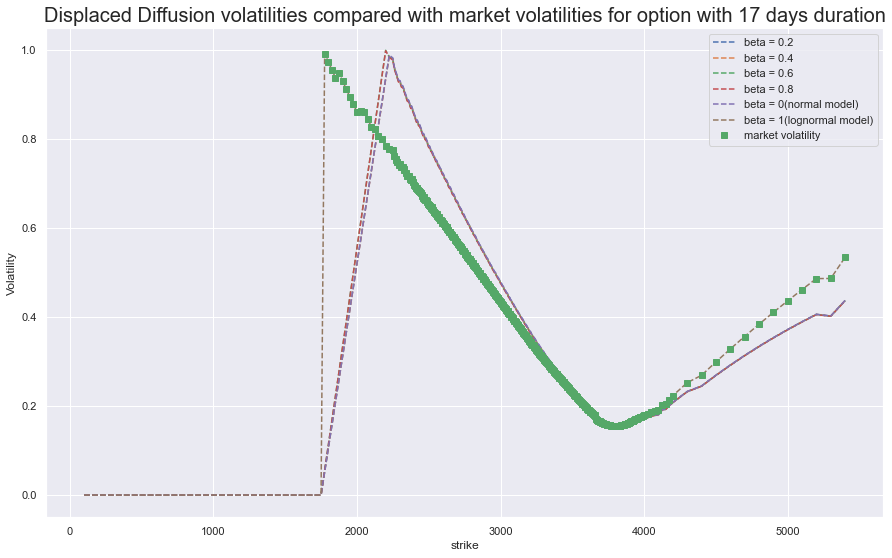

In [40]:
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd4'], label = 'beta = 0.2', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd3'], label = 'beta = 0.4', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd2'], label = 'beta = 0.6', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd1'], label = 'beta = 0.8', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_normal'], label = 'beta = 0(normal model)', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_lognormal'], label = 'beta = 1(lognormal model)', linestyle = '--')
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'market volatility')
plt.legend()
plt.title('Displaced Diffusion volatilities compared with market volatilities for option with 17 days duration', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.show()

# Calibration for options with 45 days till expiration

In [14]:
spx_call2 = spx2[(spx2.cp_flag == "C")].reset_index(drop=True)
spx_put2 = spx2[(spx2.cp_flag == "P")].reset_index(drop=True)
strike2 = spx_put2["strike_price"].values

summary2 = []
for i in range(len(spx_put2.index)):
    K = strike2[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S, K, r2, spx_put2['mid_price'][i], T2)

        price_lognormal = BlackScholesPut(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedPutVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierPut(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedPutVolatility(S, K, r2, price_normal, T2)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r2, price_dd1, T2)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r2, price_dd2, T2)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r2, price_dd3, T2)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r2, price_dd4, T2)

    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S, K, r2, spx_call2['mid_price'][i], T2)

        price_lognormal = BlackScholesCall(S, K, r2, sigma2, T2)
        impliedvol_lognormal = impliedCallVolatility(S, K, r2, price_lognormal, T2)

        price_normal = BachelierCall(S, K, r2, sigma2, T2)
        impliedvol_normal = impliedCallVolatility(S, K, r2, price_normal, T2)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r2, price_dd1, T2)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r2, price_dd2, T2)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r2, price_dd3, T2)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r2, sigma2, T2, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r2, price_dd4, T2)
        
    summary2.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_2 = pd.DataFrame(summary2, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

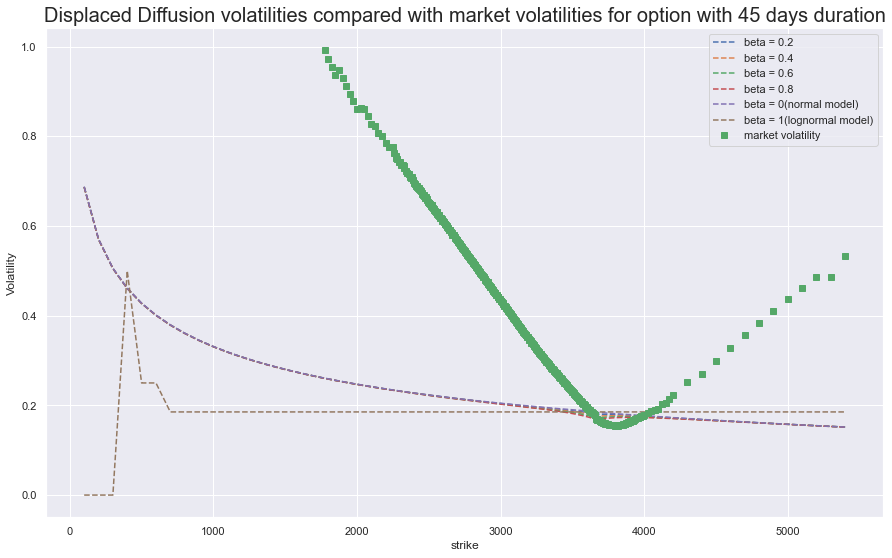

In [15]:
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd4'], label = 'beta = 0.2', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd3'], label = 'beta = 0.4', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd2'], label = 'beta = 0.6', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_dd1'], label = 'beta = 0.8', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_normal'], label = 'beta = 0(normal model)', linestyle = '--')
sns.lineplot(x = dd_2['strike'], y = dd_2['impliedvol_lognormal'], label = 'beta = 1(lognormal model)', linestyle = '--')
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'market volatility')
plt.legend()
plt.title('Displaced Diffusion volatilities compared with market volatilities for option with 45 days duration', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.show()

# Calibration for options with 80 days till expiration

In [16]:
spx_call3 = spx3[(spx3.cp_flag == "C")].reset_index(drop=True)
spx_put3 = spx3[(spx3.cp_flag == "P")].reset_index(drop=True)
strike3 = spx_put3["strike_price"].values

summary3 = []
for i in range(len(spx_put3.index)):
    K = strike3[i]
    if K <= 3660:
        impliedvol_market = impliedPutVolatility(S, K, r3, spx_put3['mid_price'][i], T3)

        price_lognormal = BlackScholesPut(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedPutVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierPut(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedPutVolatility(S, K, r3, price_normal, T3)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r3, price_dd1, T3)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r3, price_dd2, T3)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r3, price_dd3, T3)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r3, price_dd4, T3)

    elif K > 3660:
        impliedvol_market = impliedCallVolatility(S, K, r3, spx_call3['mid_price'][i], T3)

        price_lognormal = BlackScholesCall(S, K, r3, sigma3, T3)
        impliedvol_lognormal = impliedCallVolatility(S, K, r3, price_lognormal, T3)

        price_normal = BachelierCall(S, K, r3, sigma3, T3)
        impliedvol_normal = impliedCallVolatility(S, K, r3, price_normal, T3)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r3, price_dd1, T3)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r3, price_dd2, T3)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r3, price_dd3, T3)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r3, sigma3, T3, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r3, price_dd4, T3)
        
    summary3.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_3 = pd.DataFrame(summary3, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

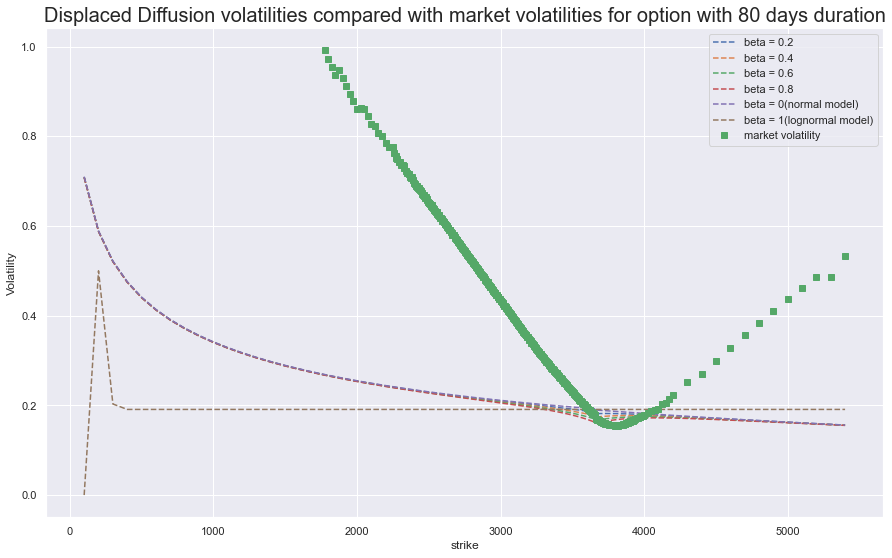

In [17]:
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd4'], label = 'beta = 0.2', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd3'], label = 'beta = 0.4', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd2'], label = 'beta = 0.6', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_dd1'], label = 'beta = 0.8', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_normal'], label = 'beta = 0(normal model)', linestyle = '--')
sns.lineplot(x = dd_3['strike'], y = dd_3['impliedvol_lognormal'], label = 'beta = 1(lognormal model)', linestyle = '--')
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'market volatility')
plt.legend()
plt.title('Displaced Diffusion volatilities compared with market volatilities for option with 80 days duration', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.show()

# SPY options Implied volatility

In [18]:
dr = pd.read_csv('zero_rates_20201201.csv')
df = pd.read_csv('SPY_options.csv')
S = 366.02
today = dt.date(2020,12,1)
expiries = [pd.Timestamp(str(x)).date() for x in df['exdate'].unique()]
T = [(exdate - today).days / 365.0 for exdate in expiries]

x = [13, 49, 77, 104]
y = [dr['rate'][1], dr['rate'][2], dr['rate'][3], dr['rate'][4]]

f = interp1d(x, y)
r17 = float(f(17))/100
r45 = float(f(45))/100
r80 = float(f(80))/100
df['cp_flag'] = df['cp_flag'].apply(lambda x: 'call' if x == 'C' else 'put')
df['price'] = (df['best_bid'] + df['best_offer']) / 2
df['duration'] = df['exdate'].apply(lambda x: (expiries[0] - today).days 
                                    if x == 20201218 
                                    else (expiries[1] - today).days if x == 20210115
                                    else (expiries[2] - today).days
                                   )


df['T'] = df['exdate'].apply(lambda x: T[0] if x == 20201218 
                             else T[1] if x == 20210115 
                             else T[2]
                            )
df['r'] = df['duration'].apply(lambda x:
                              r17 if x == 17
                              else r45 if x == 45
                              else r80)
df['strike_price'] = df['strike_price']/1000
df['Forward'] = S*np.exp(df['r']*df['T'])

for i in range(df.shape[0]):
    if df['cp_flag'][i] == 'call':
        if df['strike_price'][i] < df['Forward'][i]:
            df = df.drop(i)
    else:
        if df['strike_price'][i] > df['Forward'][i]:
            df  = df.drop(i)
df = df.reset_index(drop = True)       
impliedvol = []

In [19]:
for i in range(df.shape[0]):
    impliedvol.append(impliedVolatility(S, 
                                        df['strike_price'][i], 
                                        df['r'][i], 
                                        df['price'][i], 
                                        df['T'][i], 
                                        df['cp_flag'][i]
                                       )
                     )
df['impliedvol'] = impliedvol
days17 = df[df['exdate'] == 20201218].reset_index(drop = True)
days45 = df[df['exdate'] == 20210115].reset_index(drop = True)
days80 = df[df['exdate'] == 20210219].reset_index(drop = True)

In [20]:
T17 = days17['T'][0]
F17 = days17['Forward'][0]
T45 = days45['T'][0]
F45 = days45['Forward'][0]
T80 = days80['T'][0]
F80 = days80['Forward'][0]
R17 = df['r'].unique()[0]
R45 = df['r'].unique()[1]
R80 = df['r'].unique()[2]

In [21]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days17['strike_price'],
                                              days17['impliedvol'],
                                              F17,
                                              T17),
                    initialGuess)
alpha = res.x[0]
rho = res.x[1]
nu = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha, beta, rho, nu))

Calibrated SABR model parameters: alpha = 0.665, beta = 0.7, rho = -0.412, nu = 5.250


# Comparion of market volatilities vs SABR volatilities for options with 17 days duration

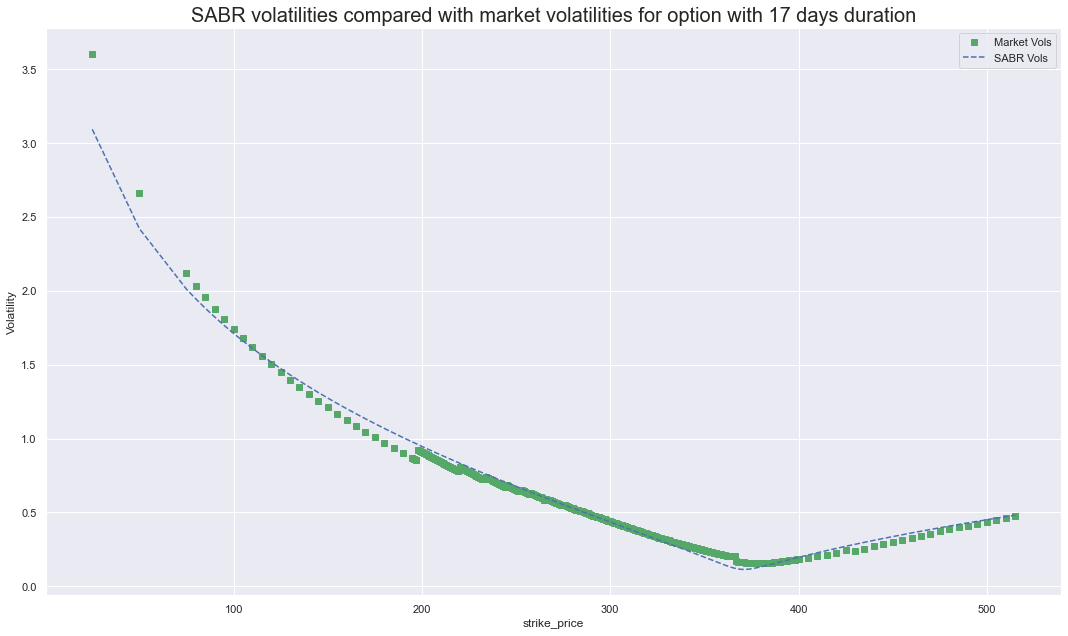

In [22]:
sabrvols = []
for K in days17['strike_price']:
    sabrvols.append(SABR(F17, K, T17, alpha, beta, rho, nu))

plt.figure(tight_layout=True)
plt.plot(days17['strike_price'], days17['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days17['strike_price'], y = sabrvols, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 17 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Comparion of market volatilities vs SABR volatilities for options with 45 days duration

In [23]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days45['strike_price'],
                                              days45['impliedvol'],
                                              F45,
                                              T45),
                    initialGuess)
alpha1 = res.x[0]
rho1 = res.x[1]
nu1 = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha1, beta, rho1, nu1))

Calibrated SABR model parameters: alpha = 0.908, beta = 0.7, rho = -0.489, nu = 2.729


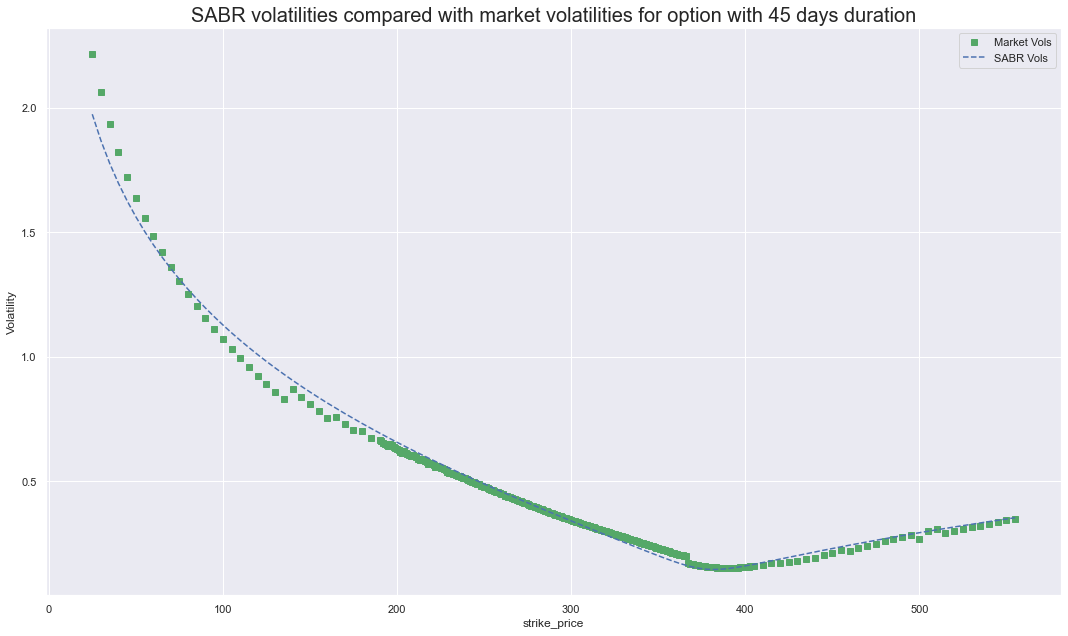

In [24]:
sabrvols1 = []
for K in days45['strike_price']:
    sabrvols1.append(SABR(F45, K, T45, alpha1, beta, rho1, nu1))

plt.figure(tight_layout=True)
plt.plot(days45['strike_price'], days45['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days45['strike_price'], y = sabrvols1, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 45 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Comparion of market volatilities vs SABR volatilities for options with 80 days duration

In [25]:
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              days80['strike_price'],
                                              days80['impliedvol'],
                                              F80,
                                              T80),
                    initialGuess)
alpha2 = res.x[0]
rho2 = res.x[1]
nu2 = res.x[2]

print('Calibrated SABR model parameters: alpha = %.3f, beta = %.1f, rho = %.3f, nu = %.3f' % (alpha2, beta, rho2, nu2))

<ipython-input-1-d27e121ebd9d>:22: RuntimeWarning: invalid value encountered in double_scalars
  zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))


Calibrated SABR model parameters: alpha = 1.121, beta = 0.7, rho = -0.633, nu = 1.742


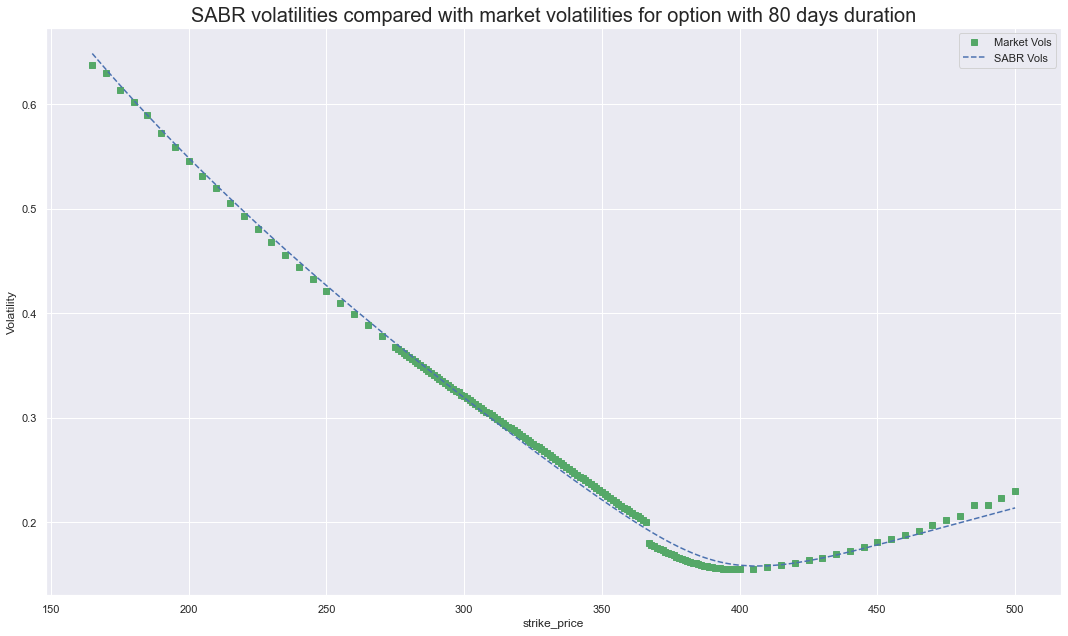

In [26]:
sabrvols2 = []
for K in days80['strike_price']:
    sabrvols2.append(SABR(F80, K, T80, alpha2, beta, rho2, nu2))

plt.figure(tight_layout=True)
plt.plot(days80['strike_price'], days80['impliedvol'], 'gs', label='Market Vols')
sns.lineplot(x = days80['strike_price'], y = sabrvols2, label = 'SABR Vols', linestyle = '--')
plt.title('SABR volatilities compared with market volatilities for option with 80 days duration', fontsize = 20)
plt.ylabel('Volatility')
plt.legend()
plt.show()

# Diffusion Displaced Model Calibration

# Calibration for options with 17 days till expiration

In [34]:
# SPX General Data
spy_df = pd.read_csv('SPY_options.csv')
spy_df['strike_price'] = spy_df['strike_price']/1000
spy_df['mid_price'] = (spy_df['best_bid'] + spy_df['best_offer'])/2

# SPX Maturity Data
spy1 = spy_df[(spy_df.exdate == 20201218)]
spy2 = spy_df[(spy_df.exdate == 20210115)]
spy3 = spy_df[(spy_df.exdate == 20210219)]

# Underlying Value & ATM Strike Price
S = 366.02
K = 365
## At The Money Volatility (ExDate: 2020/12/18)
atm_call1 = spy1[(spy1.strike_price == K)]
atm_call1 = atm_call1[(atm_call1.cp_flag == "C")]
atm_put1 = spy1[(spy1.strike_price == K)]
atm_put1 = atm_put1[(atm_put1.cp_flag == "P")]
sigma_call1 = impliedCallVolatility(S, K, r1 , atm_call1.mid_price, T1)
sigma_put1 = impliedPutVolatility(S, K, r1, atm_put1.mid_price, T1)
sigma1 = (sigma_call1 + sigma_put1)/2

## At The Money Volatility (ExDate: 2021/1/15)
atm_call2 = spy2[(spy2.strike_price == K)]
atm_call2 = atm_call2[(atm_call2.cp_flag == "C")]
atm_put2 = spy2[(spy2.strike_price == K)]
atm_put2 = atm_put2[(atm_put2.cp_flag == "P")]
sigma_call2 = impliedCallVolatility(S, K, r2 , atm_call2.mid_price, T2)
sigma_put2 = impliedPutVolatility(S, K, r2, atm_put2.mid_price, T2)
sigma2 = (sigma_call2 + sigma_put2)/2

## At The Money Volatility (ExDate: 2021/2/19)
atm_call3 = spy3[(spy3.strike_price == K)]
atm_call3 = atm_call3[(atm_call3.cp_flag == "C")]
atm_put3 = spy3[(spy3.strike_price == K)]
atm_put3 = atm_put3[(atm_put3.cp_flag == "P")]
sigma_call3 = impliedCallVolatility(S, K, r3 , atm_call3.mid_price, T3)
sigma_put3 = impliedPutVolatility(S, K, r3, atm_put3.mid_price, T3)
sigma3 = (sigma_call3 + sigma_put3)/2


In [35]:
# Displaced Diffusion Volatility (exdate1)
spy_call1 = spy1[(spy1.cp_flag == "C")].reset_index(drop=True)
spy_put1 = spy1[(spy1.cp_flag == "P")].reset_index(drop=True)
strike1 = spy_put1["strike_price"].values

summary1 = []
for i in range(len(spy_put1.index)):
    K = strike1[i]
    if K <= 365:
        impliedvol_market = impliedPutVolatility(S, K, r1, spy_put1['mid_price'][i], T1)

        price_lognormal = BlackScholesPut(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedPutVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierPut(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedPutVolatility(S, K, r1, price_normal, T1)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r1, price_dd4, T1)

    elif K > 365:
        impliedvol_market = impliedCallVolatility(S, K, r1, spy_call1['mid_price'][i], T1)

        price_lognormal = BlackScholesCall(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedCallVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierCall(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedCallVolatility(S, K, r1, price_normal, T1)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r1, price_dd4, T1)
        
    summary1.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_1 = pd.DataFrame(summary1, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

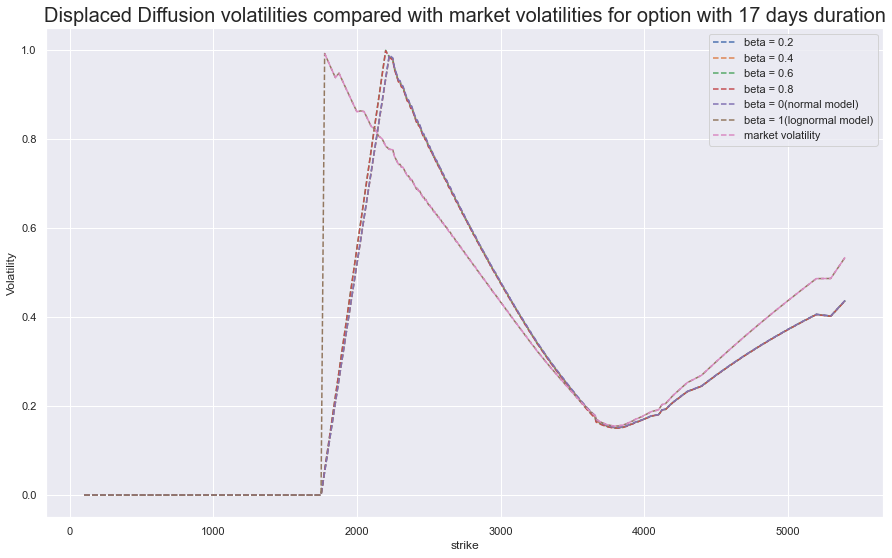

In [41]:
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd4'], label = 'beta = 0.2', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd3'], label = 'beta = 0.4', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd2'], label = 'beta = 0.6', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd1'], label = 'beta = 0.8', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_normal'], label = 'beta = 0(normal model)', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_lognormal'], label = 'beta = 1(lognormal model)', linestyle = '--')
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], '--', label = 'market volatility')
plt.legend()
plt.title('Displaced Diffusion volatilities compared with market volatilities for option with 17 days duration', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.show()

# Calibration for options with 45 days till expiration

In [37]:
# Displaced Diffusion Volatility (exdate1)
spy_call1 = spy2[(spy2.cp_flag == "C")].reset_index(drop=True)
spy_put1 = spy2[(spy2.cp_flag == "P")].reset_index(drop=True)
strike1 = spy_put1["strike_price"].values

summary1 = []
for i in range(len(spy_put1.index)):
    K = strike1[i]
    if K <= 365:
        impliedvol_market = impliedPutVolatility(S, K, r1, spy_put1['mid_price'][i], T1)

        price_lognormal = BlackScholesPut(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedPutVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierPut(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedPutVolatility(S, K, r1, price_normal, T1)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r1, price_dd4, T1)

    elif K > 365:
        impliedvol_market = impliedCallVolatility(S, K, r1, spy_call1['mid_price'][i], T1)

        price_lognormal = BlackScholesCall(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedCallVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierCall(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedCallVolatility(S, K, r1, price_normal, T1)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r1, price_dd4, T1)
        
    summary1.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_1 = pd.DataFrame(summary1, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

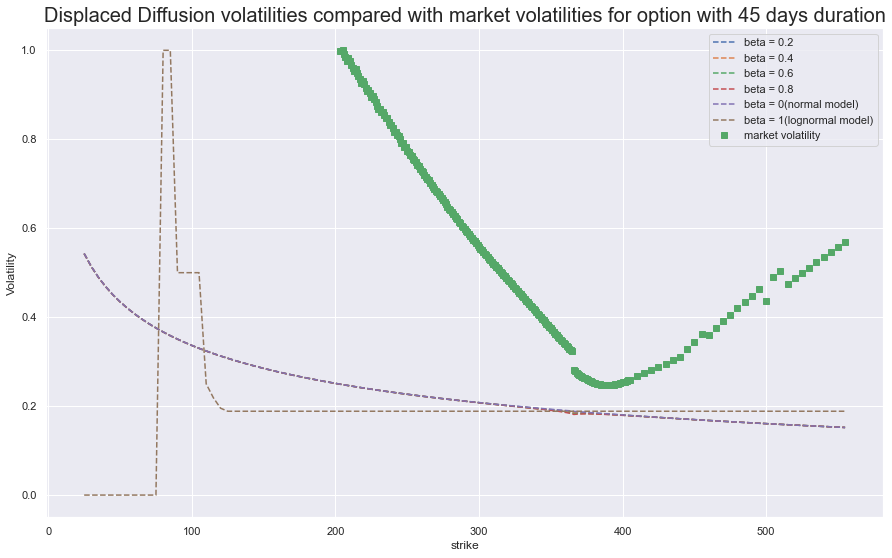

In [38]:
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd4'], label = 'beta = 0.2', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd3'], label = 'beta = 0.4', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd2'], label = 'beta = 0.6', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd1'], label = 'beta = 0.8', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_normal'], label = 'beta = 0(normal model)', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_lognormal'], label = 'beta = 1(lognormal model)', linestyle = '--')
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'market volatility')
plt.legend()
plt.title('Displaced Diffusion volatilities compared with market volatilities for option with 45 days duration', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.show()

# Calibration for options with 80 days till expiration

In [39]:
# Displaced Diffusion Volatility (exdate1)
spy_call1 = spy3[(spy3.cp_flag == "C")].reset_index(drop=True)
spy_put1 = spy3[(spy3.cp_flag == "P")].reset_index(drop=True)
strike1 = spy_put1["strike_price"].values

summary1 = []
for i in range(len(spy_put1.index)):
    K = strike1[i]
    if K <= 365:
        impliedvol_market = impliedPutVolatility(S, K, r1, spy_put1['mid_price'][i], T1)

        price_lognormal = BlackScholesPut(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedPutVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierPut(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedPutVolatility(S, K, r1, price_normal, T1)
    
        price_dd1 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedPutVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedPutVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedPutVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionPut(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedPutVolatility(S, K, r1, price_dd4, T1)

    elif K > 365:
        impliedvol_market = impliedCallVolatility(S, K, r1, spy_call1['mid_price'][i], T1)

        price_lognormal = BlackScholesCall(S, K, r1, sigma1, T1)
        impliedvol_lognormal = impliedCallVolatility(S, K, r1, price_lognormal, T1)

        price_normal = BachelierCall(S, K, r1, sigma1, T1)
        impliedvol_normal = impliedCallVolatility(S, K, r1, price_normal, T1)
       
        price_dd1 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta1)
        impliedvol_dd1 = impliedCallVolatility(S, K, r1, price_dd1, T1)
        
        price_dd2 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta2)
        impliedvol_dd2 = impliedCallVolatility(S, K, r1, price_dd2, T1)
        
        price_dd3 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta3)
        impliedvol_dd3 = impliedCallVolatility(S, K, r1, price_dd3, T1)
        
        price_dd4 = DisplacedDiffusionCall(S, K, r1, sigma1, T1, beta4)
        impliedvol_dd4 = impliedCallVolatility(S, K, r1, price_dd4, T1)
        
    summary1.append([K, 
                    impliedvol_market, 
                    impliedvol_lognormal,
                    impliedvol_normal, 
                    impliedvol_dd1,
                    impliedvol_dd2,
                    impliedvol_dd3,
                    impliedvol_dd4,
                    ])
    
dd_1 = pd.DataFrame(summary1, columns=['strike', 
                                        'impliedvol_market',
                                        'impliedvol_lognormal', 
                                        'impliedvol_normal', 
                                        'impliedvol_dd1',
                                        'impliedvol_dd2',
                                        'impliedvol_dd3',
                                        'impliedvol_dd4'
                                        ])

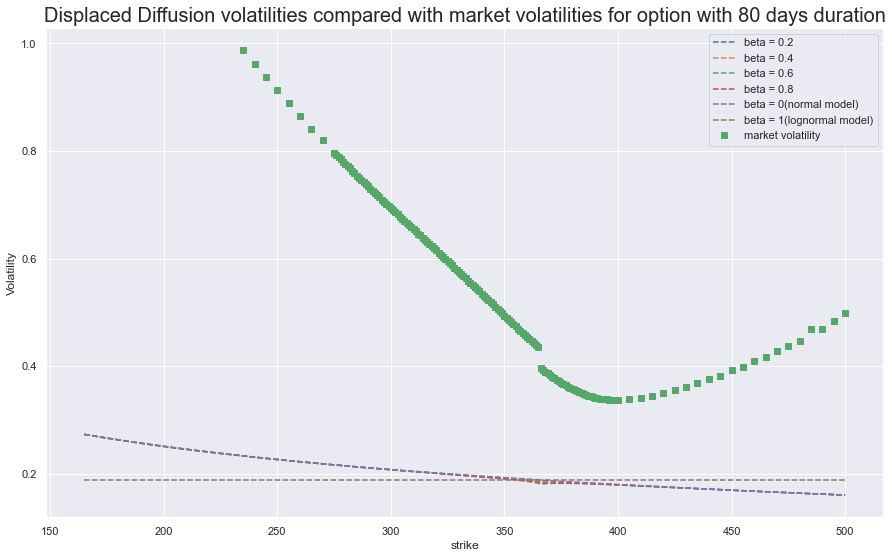

In [40]:
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd4'], label = 'beta = 0.2', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd3'], label = 'beta = 0.4', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd2'], label = 'beta = 0.6', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_dd1'], label = 'beta = 0.8', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_normal'], label = 'beta = 0(normal model)', linestyle = '--')
sns.lineplot(x = dd_1['strike'], y = dd_1['impliedvol_lognormal'], label = 'beta = 1(lognormal model)', linestyle = '--')
plt.plot(dd_1['strike'], dd_1['impliedvol_market'], 'gs', label = 'market volatility')
plt.legend()
plt.title('Displaced Diffusion volatilities compared with market volatilities for option with 80 days duration', 
          fontsize = 20)
plt.ylabel('Volatility')
plt.show()